# Lab 3: Bayesian Networks, Markov Chain Monte Carlo (MCMC) and PyMC3

In this lab we will focus on expressing probability distributions in the form of Bayesian Networks and using PyMC3 to (approximately) sample from these distributions and perform inference. 

The last set of exercises in this lab will require the use of the [`pymc3`](https://docs.pymc.io/) package so make sure to have this installed now (recommended) or before you get started on that section. If you are using conda then we recommend using the command `conda install -c anaconda pymc3`.

First, we will import the required packages for the initial exercises:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline 

## 1) Ancestral Sampling

We will first recap the concept of ancestral sampling from lectures. Familiarise yourself with the example of a simple Bayesian network shown below. 

(C=Cloudy, R=Rain, S=Sprinkler, W=Wet Grass and T/F refer to True/False)

<img src="toy_graphical_model.png" width="700">

This Bayesian network models the joint distribution over 4 variables P(**C**, **R**, **S**, **W**). To save time, the probability mass function for each of these variables are provided as Python functions below:

In [46]:
def P_C():
    return 0.5

def P_R(C):
    return 0.2 if C == False else 0.8

def P_S(C):
    return 0.5 if C == False else 0.1

def P_W(R, S):
    if R == False:
        return 0.0 if S == False else 0.9
    else:
        return 0.9 if S == False else 0.99

The concept of ancestral sampling is very simple and refers to a method of sampling from a distribution over multiple variables by first sampling from nodes in the graph that have no parents and then sampling from their child nodes conditioned on those sampled values. This process of sampling the child node variables conditioned on their parents is repeated until all nodes in the graph have a sampled value (remember that a valid graph must be acyclic so this process will always terminate with a finite number of nodes).

### 1.1) Perform Ancestral Sampling

Use the above functions to:
1. Perform ancestral sampling to generate a number of samples (~100-1000 samples) from the joint distribution. (hint [np.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) or [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) are helpful to do this)
2. Store the generated samples in a list of the form: [[$\textbf{C}_1$, $\textbf{R}_1$, $\textbf{S}_1$, $\textbf{W}_1$],[$\textbf{C}_2$, $\textbf{R}_2$, $\textbf{S}_2$, $\textbf{W}_2$], ...] where 1 and 2 refer to sample indices.

In [91]:
C = np.random.choice([True,False],500,p=[0.5, 0.5])
# print(samples)
# p(c)p(r|c)p(s|c)p(w|r,s)
# likelihood = P_C() * P_R(samples) *  P_S(samples) *  P_W(samples,samples)
# likelihood.shape
i = 1
for i in C:
    likelihood = P_C() * P_R(C[i]) * P_S(C[i]) * P_W(P_R(C[i]),P_S(C[i]))
    i++1
# likelihood = P_C() * P_R(P_C()) * P_S(P_C()) * P_W(P_R(P_C()),P_S(P_C()))
print(likelihood)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

The ability to obtain a large number of samples from the joint distribution like this is very powerful because it allows for estimates of many different quantities relating to the distribution to be calculated. Use the list of samples to compute and print out estimates of the following: 
- Marginal distributions of each variable: P(**C**), P(**R**), P(**S**) and P(**W**).
- Conditional distributions of each variable where **W**=T: P(**C** | **W**=T), P(**R** | **W**=T) and P(**S** | **W**=T) (hint discard samples where **W**=F).



In [ ]:
# marginal = 
# conditional = 
# print(marginal)
# print(conditional)

For this simple example distribution you may have noticed that exact values for all of these quantities could have been computed directly without the need for sampling. However, as we will see in the following exercises there are many cases where sampling is still feasible but exact or direct computation is not.

## 2) Markov Chain Monte Carlo

Markov Chain Monte Carlo methods are a set of algorithms with the purpose of generating samples from a distribution. Let's break down the meaning of the individual terms:
  - **Monte Carlo** simply refers to the idea of approximating a complicated system with a statistical sample.
  - A **Markov chain** refers to a stochastic process involving a number of probabilisitic state transitions from one state to another. The **Markov** property states that any given state transition probability is determined by only the current state not any of the preceding states.
 
Together, Markov Chain Monte Carlo methods are a set of methods that utilise a Markov chain to generate samples from some desired distribution. The Markov chain transition probabilites are set up in such a way that the sequence of sampled states of the chain will eventually converge to this desired distribution. Note that the initial states of the chain may be sampled from distributions far from the desired distribution which is why they are typically discarded.

### 2.1) Defining a Gaussian probability density function
We will first define a simple distribution that we intend to generate samples from. In the cell below, create a function `gaussian_pdf` that has parameters mean ($\mu$) and standard deviation ($\sigma$) and returns a function for the Gaussian probability density function corresponding to those parameters: $$\Large p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$

You are free to use the `norm` function from [`scipy.stats.norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) or define this function directly from the equation using `numpy`. Note that `gaussian_pdf` should take just two parameters (`mu` and `sigma`) and should **return a function** $p(x)$ that takes a single parameter.

For this implementation it may be useful to use a `lambda` function which is a very useful `Python` feature that allows the creation of anonymous functions. If this concept is unfamiliar to you then please see this python tutorial [here](https://www.w3schools.com/python/python_lambda.asp).

In [59]:
# def gaussian_pdf(mu,sigma):
#     def true_pdf(x):
#         pdf = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
#         return pdf
#     return true_pdf(x)

# def gaussian_pdf(x,mu,sigma):
#     pdf = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
#     return pdf

def gaussian_pdf(mu,sigma):
    def true_pdf(x):
        pdf = np.random.normal(mu, sigma)
        return pdf
    return true_pdf(x)




The code below uses this function to create and plot a Gaussian pdf with `mu=0.0` and `sigma=1.0`.

In [60]:
true_mean = 0.0
true_variance = 1.0

z = np.linspace(-5.0, 5.0, 500)
true_pdf = gaussian_pdf(mu=true_mean, sigma=np.sqrt(true_variance))
# true_pdf = gaussian_pdf(z, mu=true_mean, sigma=np.sqrt(true_variance))


plt.figure(figsize=(10,5))
plt.plot(z, true_pdf(z))
# plt.plot(z, true_pdf)

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.show()

NameError: name 'x' is not defined

### 2.2) Metropolis Algorithm

The Metropolis Algorithm is one of the simplest instances of a Markov Chain Monte Carlo method. The goal of the algorithm is to generate samples from some distribution $p(z)$ which in our case is a univariate Gaussian distribution. Let us assume that we do not have an easy way to sample from this distribution (in reality this distribution is very easy to sample from) and that we can only evaluate the unnormalised density, $\tilde{p}(z)$, where
$$\large p(z) = \frac{\tilde{p}(z)}{Z_p}$$ and $Z_p$ may be unknown or computationally intractable. 

To generate samples, $z_1, z_2, ... z_N$ , from $p(z)$ using an MCMC method such as the Metropolis algorithm we must first define a proposal distribution, $q(z_{t+1}^\star \vert z_{t})$, that uses the current state in the chain, $z_t$, to propose new states, $z_{t+1}^\star$. The only requirements for this proposal distribution are that it can easily be sampled directly and that it is symmetric (although this method can be extended for non-symmetric proposal distributions). For simplicity, in this case we will choose to use a Gaussian proposal distribution with a mean of $z_t$ and a fixed variance $\sigma_\star^2$: 
$$\large z_{t+1}^\star \sim \mathcal{N}(z_t, \sigma_\star^2)$$

[comment]: <> (At this point, to clarify, we have an unnormalised density corresponding to the distribution that we wish to be able to sample from and proposal distribution that we can easily sample from. Both distributions are Gaussian to keep things simple for this exercise but remember that this algorithm can be applied to any density.)

An initial value for the first state, $z_1$, is chosen at the beginning and is used to propose a value for the next state. The newly proposed value is either accepted as the next state in the chain, $z_2 = z_2^\star$, or it is rejected, $z_2 = z_1$. Acceptance occurs probabilistically with an acceptance probability of:
$$\large A(z_{t+1}^\star, z_t) = \text{min}\Big(1, \frac{\tilde{p}(z_{t+1}^\star)}{\tilde{p}(z_t)}\Big)$$.

Note that when $\tilde{p}(z_{t+1}^\star)\geq\tilde{p}(z_t)$ the new sample is always accepted. It turns out that if we take enough samples in this way then the distribution of $z_t$ converges to $p(z)$.

Implement the Metropolis algorithm described above and use it to generate samples from `gaussian_pdf` with `mu=0.0` and `sigma=1.0`. Set your initial sample value $z_1=0$ and the proposal distribution variance $\sigma_\star^2=0.25$. (hint sampling from the proposal distribution can be achieved using [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

The plotting functions `plot_samples` and `plot_samples_histogram` have been provided to help with visualising your implementation:
- Both functions require the `true_pdf` function and a list of generated samples `samples_list` as arguments.
- `plot_samples` generates a single plot per sample so this should be used with a small number of samples ($N\leq20$).
- `plot_samples_histogram` creates a single histogram plot and is a better visualisation for a larger number of samples ($N\geq5000$)

In [ ]:
def plot_samples(true_pdf, samples_list):
    assert len(samples_list) <= 20, "Number of samples too high! Please call this function with a maximum of 20 samples."
    for i in range(1, len(samples_list)):
        plt.figure(figsize=(10,5))
        plt.plot(z, true_pdf(z))
        for sample in samples_list[:i-1]:
            plt.axvline(sample, c='green')
        plt.axvline(samples_list[i-1], c='red')
        plt.show()

def plot_samples_histogram(true_pdf, samples_list):
    plt.figure(figsize=(10,5))
    plt.plot(z, true_pdf(z))
    plt.hist(samples_list, density=True, histtype='step', bins=50)
    plt.show()

In [ ]:
samples_list = np.random.seed()
plot_samples(true_pdf,samples_list)
plot_samples_histogram(true_pdf,samples_list)

TypeError: object of type 'NoneType' has no len()

### Exercises:
1. Estimate the mean and variance of the true distribution from your samples. How does the accuracy of these estimates change if you generate more samples?
2. The current implementation uses a normalised Gaussian pdf. Think about what would happen if the density function was unnormalised. Change `gaussian_pdf` to multiply all of its outputs by some constant value and check that you were correct.
3. Go back to Section 2.1 and experiment with different density functions:
    - Create a function `gaussian_mixture_pdf` that returns the density function for a mixture of two Gaussians with parameters: $\mu_1 = -2, \sigma_1=0.5, \mu_2=2, \sigma_2=0.5$. This can be achieved simply by creating the two density functions separately using `gaussian_pdf` and summing the result. Set this density to `true_pdf` and run the rest of your code again to generate and plot the distribution of samples from the Gaussian mixture. What do you notice about the distribution of your samples?
    - (Optional) Implement the density function for a Uniform distribution, `uniform_pdf`, over the range $(-2, 2)$ and run the code again. (hint: you can use [scipy.stats.uniform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) or implement it yourself using numpy).

# write your code here


## 3) Bayesian Linear Regression with PyMC3

You should be familiar with the concept of linear regression week 2 lectures and lab and its Bayesian formulation week 3 lectures and Bishop 3.3. In this section we will recap the key ideas and explore how such a model can be defined and fitted to some example data in practice.

### Introducing PyMC3
[PyMC3](https://docs.pymc.io/) is a library that provides a lot of useful functionality for working with probabilistic models in Python. Importantly, it allows for Bayesian networks to be programmatically defined and it provides efficient implementations of a number of different MCMC methods including the Metropolis algorithm.

If you haven't done so already then please make sure you have installed `pymc3` before proceeding.

In [ ]:
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 3.1) Generating some example data for our linear model
We will first generate some example data $\mathcal{D}=\{(x_i, y_i)\}_N$ where $$ y_i = w_0 + w_1x_i + \epsilon$$ with $w_0=6$, $w_1=2$, $\epsilon \sim \mathcal{N}(\mu=0, \sigma=1)$.

In [ ]:
n = 50
true_w0 = 6
true_w1 = 2
true_sigma = 1

x = np.linspace(0, 1, n)
y = true_w0 + true_w1*x + np.random.normal(scale=true_sigma, size=n)

Make a scatter plot of the data points and plot the line corresponding to the mean of $y$ using the known parameters.

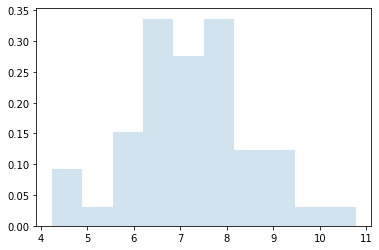

In [ ]:
plt.hist(y, density=True, histtype='stepfilled', alpha=0.2)
plt.show()

### 3.2) Bayesian Linear Regression model in PyMC3

Without knowledge of the true model parameters, the goal of Bayesian linear regression is to obtain a distribution (posterior) over the model parameters from the data, $P(w_0,w_1,\sigma \vert \mathcal{D})$. First we need to define a prior over the three parameters:
- $p(w_0) = \mathcal{N}(0, 20)$
- $p(w_1) = \mathcal{N}(0, 20)$
- $p(\sigma) = U(0, 20)$

Below is the code to define this model in `pymc3`. Note that this code performs MCMC using a No U-Turn Sampler (NUTS) which operates using the same principles as the Metropolis algorithm but is much more efficient.

In [ ]:
num_samples = 1000
with pm.Model() as model:
    # Defining our priors
    w0 = pm.Normal('w0', mu=0, sd=20)
    w1 = pm.Normal('w1', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = w0 + w1*x # auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    # inference
    sampler = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler 
    # or alternatively
    # sampler = pm.Metropolis()
    
    trace = pm.sample(num_samples, sampler, progressbar=True, cores=1, chains=2)
    

The `trace` variable now contains the sampled values from the posterior distribution for each of the model parameters. Each variable can be accessed using dictionary syntax `w1_trace = trace['w1']`. 

Make the following plots:
- Histogram of the samples of $p(w_0 \vert \mathcal{D})$, $p(w_1 \vert \mathcal{D})$ and $p(\sigma \vert \mathcal{D})$
- A two-dimensional histogram of $p(w_0, w_1 \vert \mathcal{D})$ (see [hist2d](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html)). What is the relationship between these two parameters and how do you interpret this relationship in terms of the model?
- Take a single sample from the trace and plot the line corresponding to those parameters on top of a scatter plot of the data. Use the [`errorbar`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html) function to show the variance, $\sigma$, of the noise term.

In [ ]:
# write your code here


### Exercises:
1. Experiment with changing the prior distributions within the model: 
    - How does changing the prior distributions' mean or variance affect the posterior belief?
    - What happens if the uniform distribution prior over $\sigma$ is changed to exclude the true value? (e.g. $p(\sigma) = U(5, 20)$)
    
2. Introduce a new parameter, $w_2$, to the data generation code such that
    $$ y_i = w_0 + w_1x_i + w_2x_i^2+ \epsilon$$
   and adjust the model to perform inference for this parameter from the data.

## Wrap up

This lab covered a number of topics so let's recap:
- First, we looked at a simple example of a graphical model and showed how to go about efficiently generating samples from a distribution that factorises over the graph using ancestral sampling.
- We demonstrated the power of sampling by using samples to estimate quantities relating to the distribution.
- We then looked at using the concepts of MCMC algorithms to generate samples from probability densities that are otherwise difficult to sample from and implemented the Metropolis algorithm.
- Finally, we looked at the PyMC3 python library and how its efficient implementations of MCMC algorithms can be utilised within a Bayesian Linear Regression model.

### References

- COMS30035 Machine Learning lecture notes 3.
- Bishop Pattern Recognition and Machine Learning: Chapter 3.3 for Bayesian linear regression, chapter 8.1 for graphical models and chapter 11.2 for MCMC.